In [1]:
import numpy as np # 행렬연산 패키지
import matplotlib.pyplot as plt # 그래프 패키지

#딥러닝을 위한 keras 라이브러리
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D,\
Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


### Load Dataset

In [2]:
# .npy 파일을 load 한다.
x_train = np.load('dataset/x_train.npy')  # CT 이미지
y_train = np.load('dataset/y_train.npy')  # 폐 영역 마스크 이미지
x_val = np.load('dataset/x_val.npy')      # validation 이미지 로드
y_val = np.load('dataset/y_val.npy')

print(x_train.shape, y_train.shape)
# (x)(240, 256, 256, 1) : 트레이닝 셋 : 240개, 인풋이미지 : 256x256 사이즈, 1채널(그레이 스케일)
# (y)(240, 256, 256, 1) : 아웃풋도 동일하다.
print(x_val.shape, y_val.shape) 
# (27, 256, 256, 1) (27, 256, 256, 1) : 밸리데이션 셋 : 27개, 인풋 / 아웃풋 사이즈와 색상 동일

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


### Build Model

In [3]:
inputs = Input(shape=(256,256,1)) # 인풋은 256x256 사이즈, 1채널(그레이 스케일)

# 차원의 크기를 줄인다.
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
# 컨볼루션 2D 레이어가 들어간다.
net = MaxPooling2D(pool_size=2, padding='same')(net)
# 차원을 2차원으로 줄인다.(pool_size)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net) # 학습능력 향상을 위해 Dense 레이어 추가

# 차원의 크기를 다시 늘린다.
net = UpSampling2D(size=2)(net) # UpSampling2D 를 2배(size=2)씩 해준다.
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net) # 컨볼루션 해주고 

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net) # 아웃풋이 1채널로 반환

model = Model(inputs=inputs, outputs=outputs) # 인풋, 아웃풋을 정해준다.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])
# 옵티마이저 : adam(잘 모를때는 아담이 가장 적절하다.)
# loss='binary_crossentropy' : 0 or 1 을 판단해준다.

model.summary()
# 256, 256 -> 128, 128 -> 64, 64 -> 32, 32 까지 줄어듦을 확인할 수 있다. (인풋)
# 32, 32 -> 64, 64 -> 128, 128 -> 256, 256 으로 늘어난 것을 확인할 수 있다. (아웃풋)
# 인풋과 아웃풋의 크기를 동일하게 설정한다. 이를 통해 컨볼루셔널 인코더/디코더 완성

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0   

### Train

In [4]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),   #fit함수로 트레이닝을 시킨다.
epochs=100, batch_size=32, callbacks=[               #epochs = 100번의 반복학습, batch_size=32
    ReduceLROnPlateau(moniter='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Train on 240 samples, validate on 27 samples
Epoch 1/100
240/240 [==============================] - 94s 392ms/step - loss: 0.5738 - acc: 0.7437 - mse: 0.1891 - val_loss: 0.5228 - val_acc: 0.7448 - val_mse: 0.1727
Epoch 2/100
240/240 [==============================] - 95s 396ms/step - loss: 0.4908 - acc: 0.7624 - mse: 0.1611 - val_loss: 0.4697 - val_acc: 0.7467 - val_mse: 0.1568
Epoch 3/100
240/240 [==============================] - 93s 387ms/step - loss: 0.4435 - acc: 0.7627 - mse: 0.1461 - val_loss: 0.4985 - val_acc: 0.7467 - val_mse: 0.1719
Epoch 4/100
240/240 [==============================] - 93s 388ms/step - loss: 0.4534 - acc: 0.7621 - mse: 0.1518 - val_loss: 0.4293 - val_acc: 0.7467 - val_mse: 0.1420
Epoch 5/100
240/240 [==============================] - 93s 386ms/step - loss: 0.4426 - acc: 0.7626 - mse: 0.1472 - val_loss: 0.4361 - val_acc: 0.7465 - val_mse: 0.1440
Epoch 6/100
240/240 [==============================] - 93s 389ms/step - loss: 0.4281 - acc: 0.7627 - mse: 0.1419 - 

### Evaluation

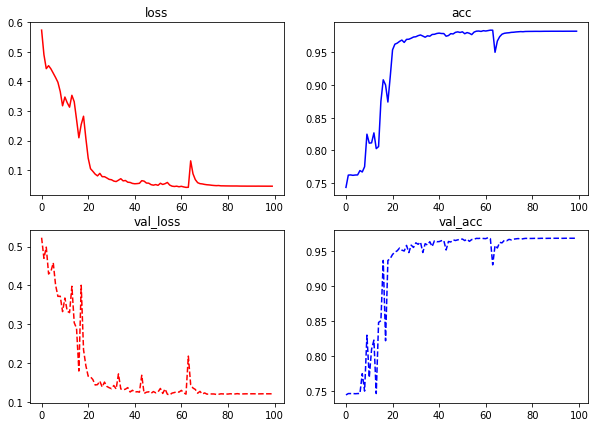

In [5]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].set_title('loss')
ax[0,0].plot(history.history['loss'], 'r') # 그래프를 그려준다. 히스토리의 히스토리 오브젝트에서 loss에도 접근 가능하고
ax[0,1].set_title('acc')
ax[0,1].plot(history.history['acc'], 'b') # accuracy 에도 접근 가능

ax[1,0].set_title('val_loss')
ax[1,0].plot(history.history['val_loss'],'r--') # validation loss에도 접근 가능
ax[1,1].set_title('val_acc')
ax[1,1].plot(history.history['val_acc'], 'b--') # validation accuracy에도 접근 가능 --> 모두 접근하여 그래프를 그린다.
# 1행이 트레이닝 결과
# 2행이 밸리데이션 결과

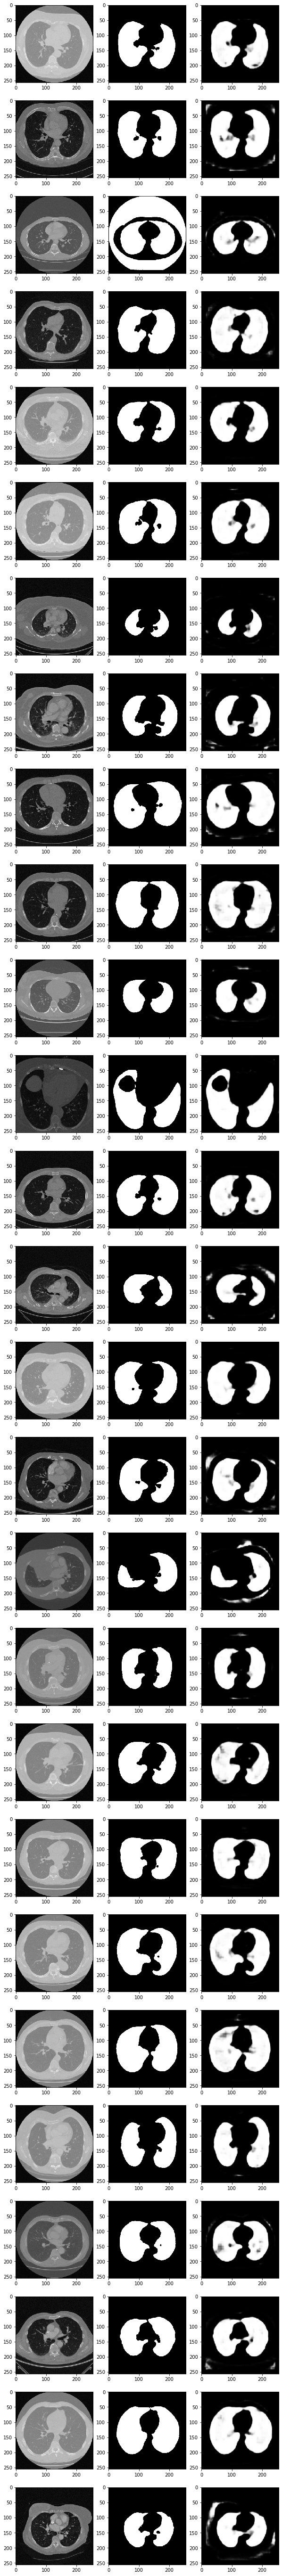

In [6]:
preds = model.predict(x_val) # predict 함수를 통해 (x_val) 검증한다

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):  
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray') # 첫 번째 열에는 CT 데이터(x_val[i])를 삽입
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray') # 두 번째 열에는 정답 데이터를 넣는다.
    ax[i, 2].imshow(pred.squeeze(), cmap='gray') # 세 번째 열에는 우리가 예측한 결과값을 그려본다.

# 이러한 딥러닝을 활용하여 산소의 수치, 적혈구, 백혈구의 농도 등 수치적 데이터를 가지고 예측하는 방법도 존재함.